## Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('~/Downloads/3stations-7k.csv')

In [3]:
df = df[['transit_timestamp', 'station_complex_id', 'borough', 'fare_class_category', 'ridership']]
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df.head()

/var/folders/sq/wp5xsw8j32nc80nbtg57p5p40000gn/T/ipykernel_54205/899050565.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


,transit_timestamp,station_complex_id,borough,fare_class_category,ridership
0,2024-10-18 16:00:00,10,Manhattan,OMNY - Other,3
1,2024-10-18 23:00:00,10,Manhattan,OMNY - Other,1
2,2024-10-22 14:00:00,10,Manhattan,OMNY - Other,3
3,2024-10-17 11:00:00,10,Manhattan,Metrocard - Fair Fare,9
4,2024-10-17 05:00:00,10,Manhattan,Metrocard - Other,3


In [4]:
df_10 = df

In [5]:
import datetime
from sklearn.preprocessing import OneHotEncoder

def prepare(df):
    df = df.copy()
    df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
    df['day_of_week'] = df['transit_timestamp'].dt.dayofweek
    df['hour_of_day'] = df['transit_timestamp'].dt.hour
    df['month_of_year'] = df['transit_timestamp'].dt.month
    df['day_of_month'] = df['transit_timestamp'].dt.day
    df['year'] = df['transit_timestamp'].dt.year
    # df.set_index('transit_timestamp', inplace=True)
    # df = df.drop(['transit_timestamp'], axis=1)
    
    return df

In [71]:
df_10 = prepare(df_10)
np.unique(df_10['fare_class_category'])

array(['Metrocard - Fair Fare', 'Metrocard - Full Fare',
       'Metrocard - Other', 'Metrocard - Seniors & Disability',
       'Metrocard - Students', 'Metrocard - Unlimited 30-Day',
       'Metrocard - Unlimited 7-Day', 'OMNY - Fair Fare',
       'OMNY - Full Fare', 'OMNY - Other', 'OMNY - Seniors & Disability',
       'OMNY - Students'], dtype=object)

In [7]:
def prepare2(df):
    ohe = OneHotEncoder(feature_name_combiner='concat')
    f = ohe.fit_transform(df[['station_complex_id','fare_class_category', 'borough']])

    X_ohe = pd.DataFrame(f.toarray(), columns=ohe.get_feature_names_out())
    
    df = df.drop(['fare_class_category', 'station_complex_id', 'borough'], axis=1)

    X = df
    # from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    # scaler = MinMaxScaler()
    # X_scaled = scaler.fit_transform(X)
    # X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    X =  pd.concat([X, X_ohe], axis=1)
    X = X.drop(['transit_timestamp'], axis=1)

    return X #, y

In [8]:
X = prepare2(df_10)

In [9]:
df_train, df_test = X[(X['year'] <= 2023) &  (X['year'] >= 2022)], X[X['year'] > 2023]

In [10]:
y_train = df_train['ridership']
X_train = df_train.drop(['ridership'], axis=1)

y_test = df_test['ridership']
X_test = df_test.drop(['ridership'], axis=1)

In [11]:
import matplotlib.pyplot as plt
def ground_predicted(mdl, desc=''):
    y_hat = mdl.predict(X_test)

    #fig, ax = plt.subplots()

    #plt.figure(figsize=(20, 20))
    
    plt.scatter(y_test, y_hat)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=1)
    
    #ax.set_xlabel('Actual (Ground Truth)')
    #ax.set_ylabel('Predicted')
    #ax.set_title(f"Ground Truth vs Predicted | {desc}")

## RFR w/ BayesSearchCV

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [14]:
rfmodel = RandomForestRegressor()

In [15]:
search_space = {
    'n_estimators': Integer(500,700),
    'max_depth': Integer(1, 2),
    'bootstrap': Categorical([True, False])
}

In [16]:
bayes_search_rf = BayesSearchCV(
    estimator=rfmodel,
    search_spaces=search_space,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

In [ ]:
bayes_search_rf.fit(X_train, y_train)

In [150]:
rf_bm = bayes_search_rf.best_estimator_

In [151]:
preds = rf_bm.predict(X_test)
r2_score(y_test, preds)

0.5598457690975422

In [152]:
preds = rf_bm.predict(X_train)
r2_score(y_train, preds)

0.5882724633307705

## XGBoost w/ BayesSearchCV

In [18]:
from xgboost import XGBRegressor

In [19]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [20]:
xgbmodel = XGBRegressor()

In [21]:
search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 200),
    'min_child_weight': Integer(1, 5),
    'colsample_bytree': Real(0.5, 1.0),
    'subsample': Real(0.5, 1.0)
}

In [22]:
bayes_search = BayesSearchCV(
    estimator=xgbmodel,
    search_spaces=search_space,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

In [23]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                             'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [24]:
bayes_search.best_estimator_.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7355755845134679, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.20005740830973504, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=173, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
preds = bayes_search.best_estimator_.predict(X_test)
r2_score(y_test, preds)

0.8848604559898376

In [26]:
preds = bayes_search.best_estimator_.predict(X_train)
r2_score(y_train, preds)

0.9839038252830505

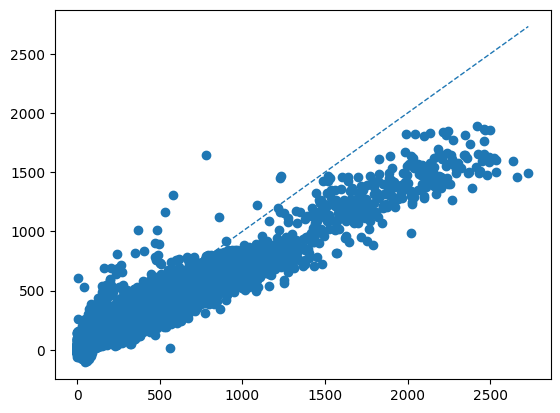

In [27]:
ground_predicted(bayes_search.best_estimator_)

## Clustering Stations Based on Ridership Patterns over a Day

In [29]:
df = pd.read_csv('~/Downloads/timeseriesclustering.csv')

In [30]:
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

In [31]:
df['hour'] = df['transit_timestamp'].dt.hour

In [32]:
df.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,hour
0,2023-02-10 08:00:00,subway,111,Seneca Av (M),Queens,omny,OMNY - Full Fare,107,2,40.702763,-73.90774,POINT (-73.90774 40.702763),8
1,2023-02-10 20:00:00,subway,240,"7 Av (F,G)",Brooklyn,omny,OMNY - Full Fare,189,0,40.666270,-73.98031,POINT (-73.98031 40.66627),20
2,2023-02-10 04:00:00,subway,224,57 St (F),Manhattan,omny,OMNY - Full Fare,1,0,40.763973,-73.97745,POINT (-73.97745 40.763973),4
3,2023-02-10 11:00:00,subway,364,Zerega Av (6),Bronx,omny,OMNY - Full Fare,17,1,40.836487,-73.84704,POINT (-73.84704 40.836487),11
4,2023-02-10 14:00:00,subway,28,Union St (R),Brooklyn,omny,OMNY - Full Fare,107,1,40.677315,-73.98311,POINT (-73.98311 40.677315),14


In [33]:
df = df[['station_complex_id', 'ridership', 'hour']]

In [34]:
df = df.groupby(['station_complex_id', 'hour']).mean()

In [35]:
import matplotlib.pyplot as plt

In [36]:
df_1 = df[df.index.get_level_values('station_complex_id') == '13']
df_2 = df[df.index.get_level_values('station_complex_id') == '28']

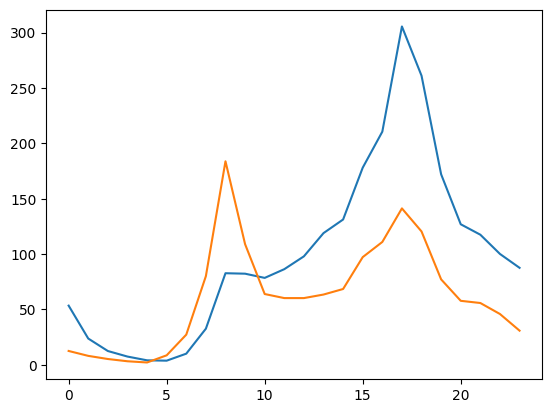

In [37]:
plt.plot(df_1.index.get_level_values('hour'), df_1['ridership']) 
plt.plot(df_2.index.get_level_values('hour'), df_2['ridership']) 

In [38]:
fin = []
scids = []
for scid in np.unique(df.index.get_level_values('station_complex_id')):
    if 'TRAM' in scid:
        continue
    b = [scid]
    for i in range(24):
        b.append(int(df[df.index == (scid, i)]['ridership']))
        scids.append(scid)
    fin.append(b)

/var/folders/sq/wp5xsw8j32nc80nbtg57p5p40000gn/T/ipykernel_54205/106489404.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  b.append(int(df[df.index == (scid, i)]['ridership']))


In [40]:
df_ts = pd.DataFrame(fin, columns=['station_complex_id'] + list(range(24)))

In [69]:
df_ts

,station_complex_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,11,5,4,4,12,54,143,297,454,...,156,168,166,171,135,81,59,43,42,20
1,10,81,29,15,9,6,7,18,48,113,...,219,283,429,699,562,331,245,313,264,160
2,100,6,4,3,2,2,4,13,27,64,...,38,40,42,47,43,31,24,15,12,8
3,101,32,18,12,7,7,16,51,134,309,...,173,198,240,258,219,168,117,85,68,56
4,103,25,18,10,6,4,2,3,8,20,...,39,51,61,73,69,62,51,47,48,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,95,4,3,2,2,7,23,53,106,164,...,73,81,82,88,72,46,30,20,14,8
422,96,6,4,3,3,6,20,45,80,131,...,57,59,56,56,51,36,22,17,13,10
423,97,18,13,13,9,12,28,65,149,284,...,121,137,135,153,128,90,59,45,42,28
424,98,8,4,3,2,4,12,33,57,90,...,98,107,135,135,95,61,47,25,21,16


In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()

In [44]:
t = []
for i in range(len(df_ts)):
    t.append( [df_ts.iloc[i]['station_complex_id']] + scaler.fit_transform(np.array(df_ts.iloc[i][1:]).reshape(-1, 1)).reshape(24).tolist())

df_tsscaled = pd.DataFrame(t, columns=['station_complex_id'] + list(range(24)))

In [45]:
from tslearn.clustering import KShape

In [54]:
df_avg_clust = df_5.drop('station_complex_id', axis=1).groupby('cluster').mean()
df_avg_clust

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cluster,,,,,,,,,,,,,,,,,,,,,
0,5.449827,3.186851,2.397924,2.972318,9.833910,38.750865,80.252595,133.667820,159.432526,100.32526,...,72.854671,79.439446,82.671280,87.397924,66.508651,42.833910,29.702422,23.346021,18.505190,10.508651
1,37.240000,20.180000,11.980000,7.220000,7.140000,27.100000,78.200000,165.140000,286.780000,200.14000,...,175.380000,214.100000,260.500000,307.320000,258.380000,175.080000,134.120000,121.920000,110.020000,66.040000
2,46.275862,20.862069,10.977011,6.367816,5.781609,14.068966,48.287356,124.436782,233.977011,175.91954,...,268.885057,362.643678,484.390805,661.298851,504.356322,304.781609,206.229885,162.241379,128.735632,84.287356


In [58]:
def plot_clusters(clust, ax):
    cluster_data = df_5[ df_5['cluster'] == clust ].drop('station_complex_id', axis=1).sample(13, replace=True).iloc[:]
    ax.plot(list(range(24)), df_avg_clust[df_avg_clust.index == clust].sample(13, replace=True).iloc[:].T.values, color='red', alpha=1)
    for station in cluster_data.T.values.T:
        ax.plot(list(range(24)), station[1:], alpha=0.2)

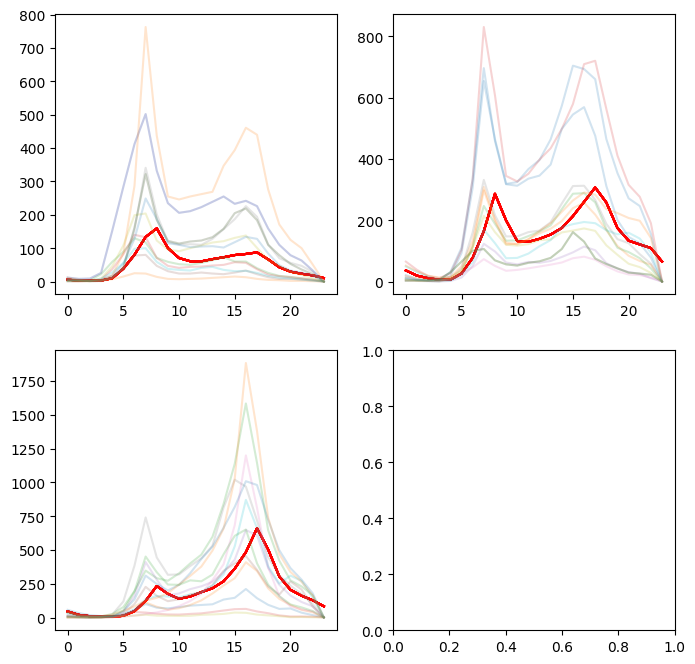

In [59]:
ks = KShape(n_clusters=3, random_state=0)
clusters = ks.fit_predict(df_ts.drop('station_complex_id', axis=1))
df_5 = df_ts.copy()
df_5['cluster'] = clusters
df_avg_clust = df_5.drop('station_complex_id', axis=1).groupby('cluster').mean()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plot_clusters(0, ax[0][0])
plot_clusters(1, ax[0][1])
plot_clusters(2, ax[1][0])

In [60]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import geodatasets

In [61]:
# Load New York City map
nyc_map = gpd.read_file(geodatasets.get_path('ny.bb'))

In [62]:
df12 = pd.read_csv('~/Downloads/timeseriesclustering.csv')
df12 = df12.groupby('station_complex_id')[['latitude', 'longitude']].mean()

In [63]:
colors=['red', 'blue', 'black']

In [64]:
# Create geometry column
geometry = [Point(xy) for xy in zip(df12['longitude'], df12['latitude'])]
geo_df = gpd.GeoDataFrame(df12, geometry=geometry, crs="EPSG:4326")

In [65]:
geo_df['cluster'] = df_5.set_index('station_complex_id')['cluster'].map(lambda x: colors[x])

In [66]:
geo_df = geo_df.fillna('red')

In [67]:
n_map2 = nyc_map[nyc_map['BoroName'] != 'Staten Island']

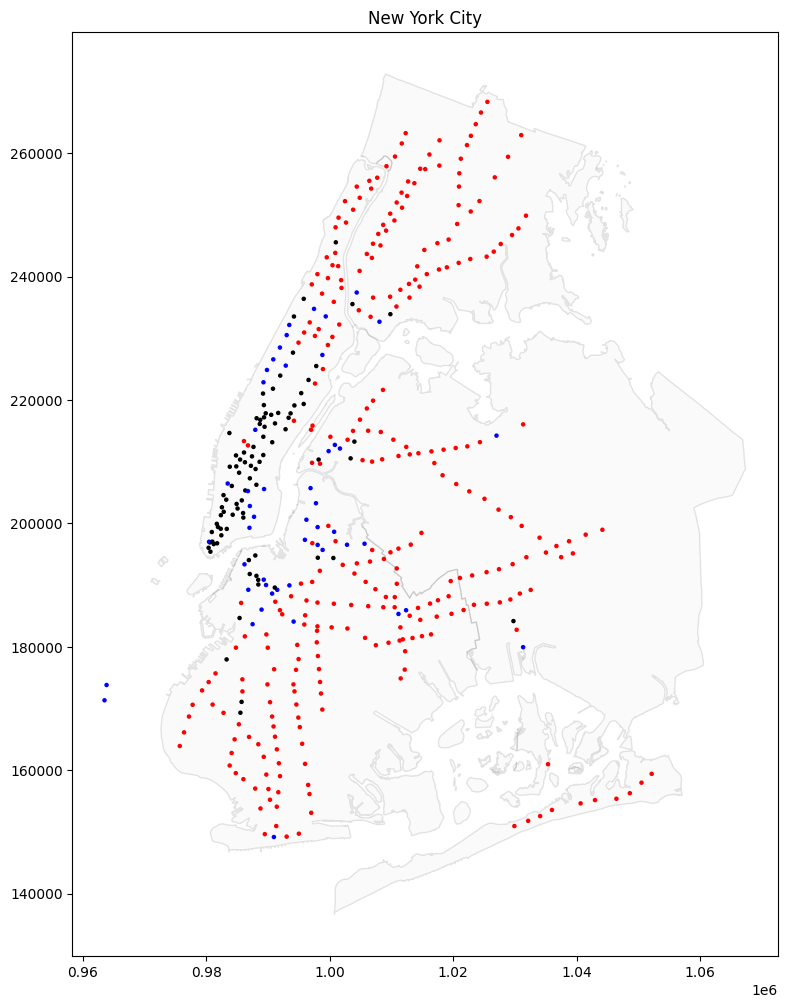

In [68]:
geo_df = geo_df.to_crs(nyc_map.crs)
# Plot the map
fig, ax = plt.subplots(figsize=(18, 12))
n_map2.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.1)

# Overlay custom points
geo_df.plot(ax=ax, markersize=5, color=geo_df['cluster'])

# Customize the plot
plt.title('New York City')
# plt.axis('off')

# Show the plot
plt.show()